### Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

### Datos y limpieza

In [2]:
df = pd.read_csv('COVID19MEXICO_ACTUALIZADO_UTF8.csv')
codigos_covid_pcr = [24, 34, 35, 36]
# Siendo codigos_covid_pcr: CORONA SARS, SARS-CoV-2, MERS-CoV, SARS-CoV (respectivamente)
df = df[(df['TOMA_MUESTRA_LAB'] == 1) | (df['RESULTADO_PCR'].isin(codigos_covid_pcr))].copy()
# Excluir filas donde se desconoce el sexo de la persona.
df = df[df['SEXO'] != 99]

# LIMPIEZA DE DATOS
columnas_base = ['EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
                'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']

valores_invalidos = [97, 98, 99]
for col in columnas_base:
    df[col] = df[col].replace(valores_invalidos, np.nan)
    df[col] = df[col].replace({1: 1, 2: 0})

df = df.dropna(subset=columnas_base + ['FALLECIDO', 'EDAD', 'SEXO'])


### UNIFICACION DE CIERTOS DATOS PARA MEJORAR LA PRECISION DEL MODELO

In [3]:
df['EDAD_GROUP'] = pd.cut(df['EDAD'], bins=[0, 20, 40, 60, 80, 100], 
                          labels=['0-20', '21-40', '41-60', '61-80', '+81'])

df['DIABETES_HIPERTENSION'] = df['DIABETES'] * df['HIPERTENSION']
df['OBESIDAD_DIABETES'] = df['OBESIDAD'] * df['DIABETES']
df['MULTIENFERMEDAD'] = df[['DIABETES', 'HIPERTENSION', 'OBESIDAD', 'RENAL_CRONICA']].sum(axis=1)

df['SEXO'] = df['SEXO'].replace({1: 0, 2: 1})

df = pd.get_dummies(df, columns=['EDAD_GROUP'], drop_first=True) # convierte las categorias de edad en binarias
#para que el modelo pueda interpretarlas de manera correcta

features = columnas_base + [
    'DIABETES_HIPERTENSION', 'OBESIDAD_DIABETES', 'MULTIENFERMEDAD',
    'EDAD_GROUP_21-40', 'EDAD_GROUP_41-60', 'EDAD_GROUP_61-80', 'EDAD_GROUP_+81',
    'SEXO', 'EDAD'
]


### PREPARACION PARA EL MODELO

In [4]:
# Preparacion del modelo,  siendo X las variables predictivas y Y las variables respuesta u objetivo
X = df[features]
y = df['FALLECIDO']
# el entrenamiento decidi ponerlo como entrenamiento 70 y de pruebas un 30%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# para ver como estan distribuido el target (fallecidos o no)
print("\nDistribución de clases original (0 No Fallecidos 1 Fallecidos):")
print(y_train.value_counts(normalize=True))

# SMOTE crea ejemplos sintéticos de la clase minoritaria (fallecidos) 
# para balancear el dataset y evitar que el modelo se sesgue hacia la clase mayoritaria.

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))



Distribución de clases original (0 No Fallecidos 1 Fallecidos):
FALLECIDO
0    0.956623
1    0.043377
Name: proportion, dtype: float64

Distribución después de SMOTE:
FALLECIDO
0    0.5
1    0.5
Name: proportion, dtype: float64


## FUNCION DE EVALUACION Y ENTRENAMIENTO DEL MODELO

### Evaluacion del modelo con umbral del 0.3


Regresión Logística

Evaluación del modelo: LogisticRegression con umbral 0.3

Métricas adicionales:
Accuracy: 0.4776
Precision: 0.0685
Recall: 0.8759
F1 Score: 0.1270
ROC AUC: 0.7658


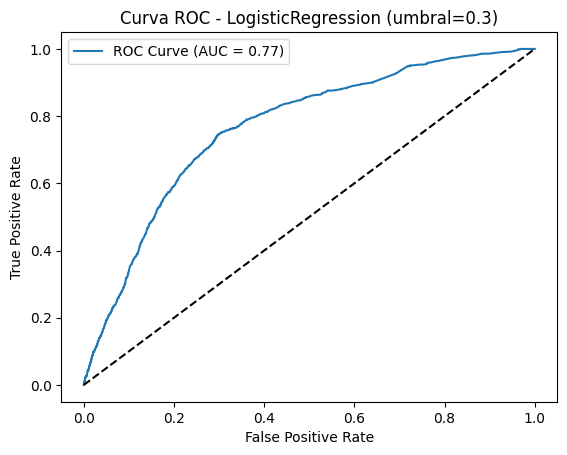

In [10]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, umbral=0.5):
    #El entrenamiento de los modelos
    modelo.fit(X_train, y_train)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= umbral).astype(int)
    # la visualizacion de los coeficientes.
    print("\n" + "="*60)
    print(f"Evaluación del modelo: {type(modelo).__name__} con umbral {umbral}")
    print("="*60)
    
    #Esto imprime las metricas de clasificacion (metricas estandar), precision, recall, f1-score y support por clase
    #print(classification_report(y_test, y_pred))
    
    #print("\nMatriz de confusión:")
    #matriz = confusion_matrix(y_test, y_pred)
    #print(f"Real 0 (No Fallecido)\t{matriz[0,0]} → Verdaderos Negativos (VN)\t\t{matriz[0,1]} → Falsos Positivos (FP)")
    #print(f"Real 1 (Fallecido)\t{matriz[1,0]} → Falsos Negativos (FN)\t\t{matriz[1,1]} → Verdaderos Positivos (VP)")
    # 
    print("\nMétricas adicionales:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    #X (Falso Positivo Rate):
    #Proporción de personas que no fallecieron, pero el modelo predijo que sí.
    
    #Y (True Positive Rate):
    #Proporción de personas que sí fallecieron, y el modelo lo predijo correctamente.

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {type(modelo).__name__} (umbral={umbral})')
    plt.legend()
    plt.show()

    return modelo
print("\n" + "="*60)
print("Regresión Logística")
print("="*60)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg = evaluar_modelo(log_reg, X_train_res, y_train_res, X_test_scaled, y_test, umbral=0.3)

### GRAFICAS DE LOS COEFICIENTES

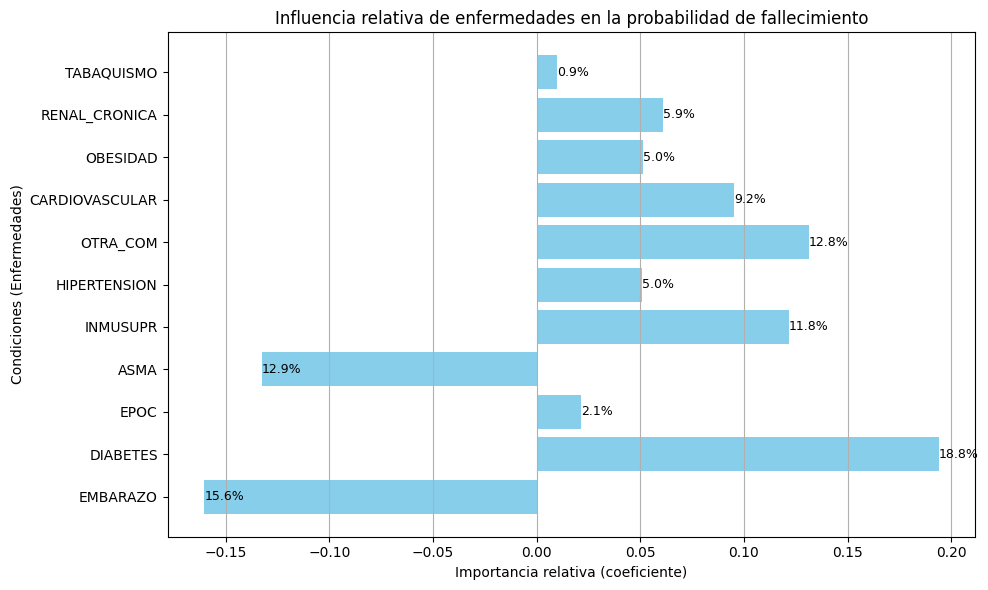

In [6]:
coef = log_reg.coef_[0]
feature_names = np.array(features)

excluir = ['EDAD', 'DIABETES_HIPERTENSION', 'OBESIDAD_DIABETES', 'MULTIENFERMEDAD', 'SEXO']
mask = [not any(x in f for x in excluir) for f in feature_names]

feature_names_filtered = feature_names[mask]
coef_filtered = coef[mask]

import numpy as np
percentages = 100 * np.abs(coef_filtered) / np.sum(np.abs(coef_filtered))

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names_filtered, coef_filtered, color='skyblue')

for bar, pct in zip(bars, percentages):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}%', va='center', ha='left', fontsize=9)

plt.title("Influencia relativa de enfermedades en la probabilidad de fallecimiento")
plt.xlabel("Importancia relativa (coeficiente)")
plt.ylabel("Condiciones (Enfermedades)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### EC. DE REGRESION L. CON FORMATO

In [7]:
intercepto = log_reg.intercept_[0]
expresion = " + ".join([f"{c:.4f}·{f}" for c, f in zip(coef, feature_names)])
print("\nEcuación de regresión logística (log-odds):")
print(f"logit(p) = {expresion} + {intercepto:.4f}")



Ecuación de regresión logística (log-odds):
logit(p) = -0.1604·EMBARAZO + 0.1939·DIABETES + 0.0212·EPOC + -0.1326·ASMA + 0.1218·INMUSUPR + 0.0510·HIPERTENSION + 0.1314·OTRA_COM + 0.0951·CARDIOVASCULAR + 0.0515·OBESIDAD + 0.0608·RENAL_CRONICA + 0.0097·TABAQUISMO + -0.1034·DIABETES_HIPERTENSION + -0.0543·OBESIDAD_DIABETES + 0.1377·MULTIENFERMEDAD + -0.4451·EDAD_GROUP_21-40 + -0.2387·EDAD_GROUP_41-60 + -0.0406·EDAD_GROUP_61-80 + 0.0035·EDAD_GROUP_+81 + 0.0000·SEXO + 0.5497·EDAD + -0.4457


## GRAFICA DE BURBUJA

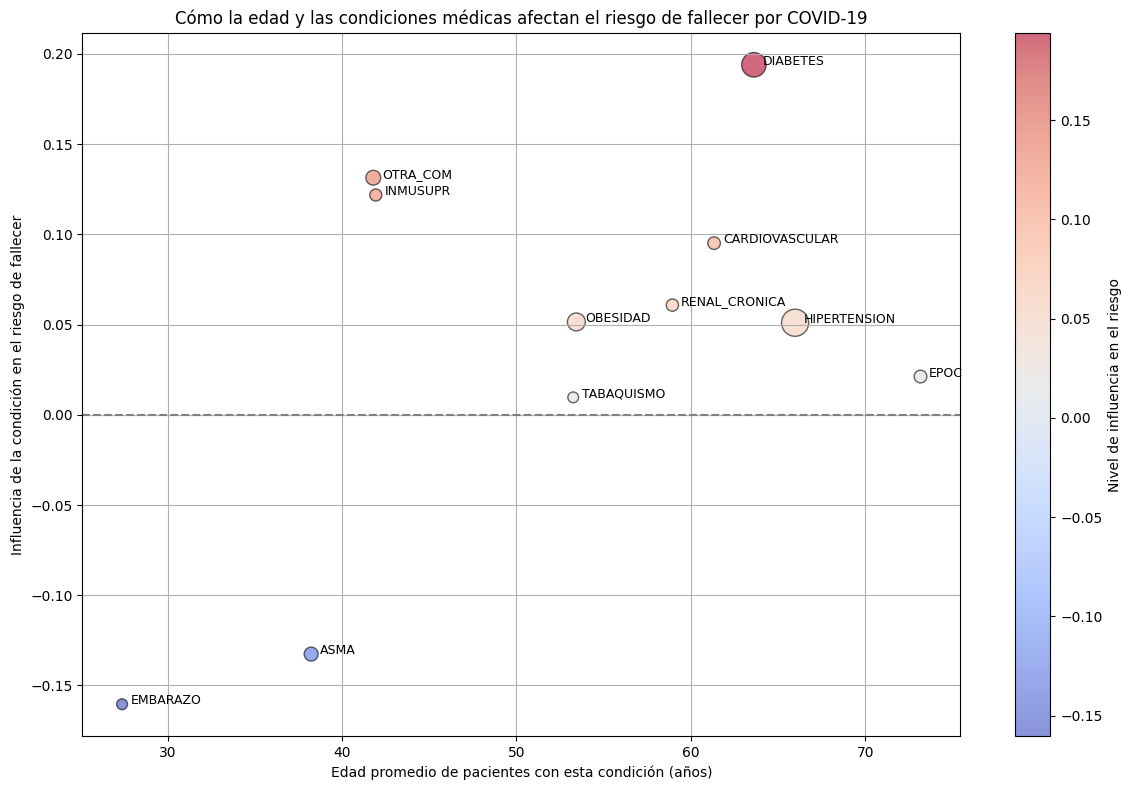

In [53]:
# Extraer edad promedio por condición
enfermedades = feature_names_filtered  # ya excluye sexo, edad, interacciones
coef_enfermedades = coef_filtered

# Calcular edad promedio y frecuencia para cada enfermedad
edades_promedio = []
frecuencias = []

for enfermedad in enfermedades:
    edad_prom = df[df[enfermedad] == 1]['EDAD'].mean()
    frecuencia = df[enfermedad].mean()  # proporción de pacientes con esa enfermedad
    edades_promedio.append(edad_prom)
    frecuencias.append(frecuencia)

#normalizacion de frecuencia para usar como tamaño de burbuja
sizes = np.array(frecuencias) * 2000  #escala para que se vean bien

plt.figure(figsize=(12, 8))
scatter = plt.scatter(edades_promedio, coef_enfermedades, s=sizes, alpha=0.6, c=coef_enfermedades, cmap='coolwarm', edgecolors='k')

# Agregar etiquetas a cada burbuja
for i, enfermedad in enumerate(enfermedades):
    plt.text(edades_promedio[i]+0.5, coef_enfermedades[i], enfermedad, fontsize=9)

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Edad promedio de pacientes con esta condición (años)")
plt.ylabel("Influencia de la condición en el riesgo de fallecer")
plt.title("Cómo la edad y las condiciones médicas afectan el riesgo de fallecer por COVID-19")
plt.colorbar(label='Nivel de influencia en el riesgo')
plt.grid(True)
plt.tight_layout()
plt.show()



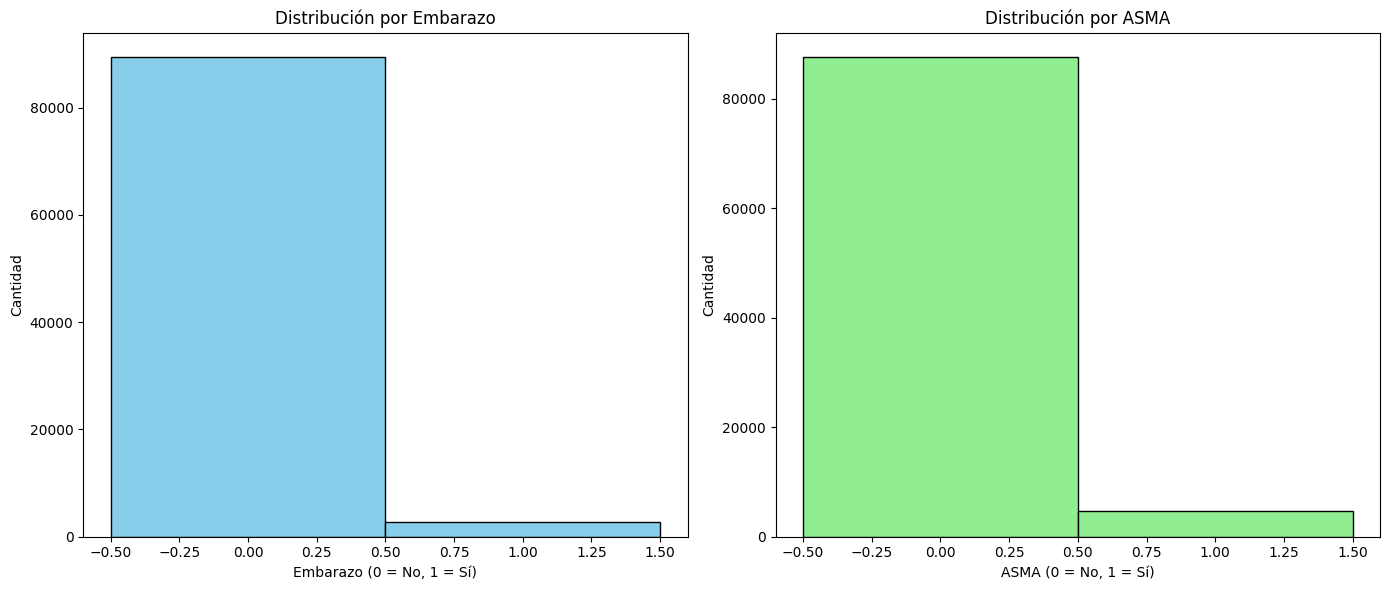

In [67]:
import matplotlib.pyplot as plt

# Asegúrate de que los nombres de las columnas son correctos
col_embarazo = 'EMBARAZO'
col_asma = 'ASMA'
col_fallecido = 'FALLECIDO'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma de Embarazo (sin diferenciar fallecidos)
axes[0].hist(
    df[col_embarazo],
    bins=[-0.5, 0.5, 1.5],
    color='skyblue',
    edgecolor='black'
)
axes[0].set_title('Distribución por Embarazo')
axes[0].set_xlabel('Embarazo (0 = No, 1 = Sí)')
axes[0].set_ylabel('Cantidad')

# Histograma de ASMA (sin diferenciar fallecidos)
axes[1].hist(
    df[col_asma],
    bins=[-0.5, 0.5, 1.5],
    color='lightgreen',
    edgecolor='black'
)
axes[1].set_title('Distribución por ASMA')
axes[1].set_xlabel('ASMA (0 = No, 1 = Sí)')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()
